NLP sentiment analysis of IMDB reviews dataset using a LSTM recurrent neural network, licensed under the [Apache License, Version 2.0](http://www.apache.org/licenses/LICENSE-2.0)

# Table of contents
* [Main libraries](#libraries)
* [IMDB dataset](#IMDB)
* [Data preprocessing](#preprocessing)
* [Data splitting and tokenization](#splitting)
* [LSTM Model](#LSTM)

<a id='libraries'></a>
# Main libraries
We start by importing the main libraires we shall use:

- the [re](https://docs.python.org/3/library/re.html) module (for regular expression matching operations)
- the [nltk](https://www.nltk.org/) toolkit (for natural language operations)
- the [numpy](https://numpy.org/) library (for arrays operations)
- the [pandas](https://pandas.pydata.org/) library (for data analysis)
- the [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html) module (for statistics)
- the [matplotlib.pyplot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html) interface (for MATLAB-like plots)

We also download (if not already done) the "stopwords" and "punkt" [data packages](https://www.nltk.org/data.html) from the nltk toolkit.

In [1]:
import re
import nltk
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

# nltk.download('punkt')
# nltk.download('stopwords')

<a id='IMDB'></a>
# IMDB dataset
We retrieve from [Kaggle](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews?resource=download) the csv file "IMDB Dataset.csv" consisting of 50'000 IMDB movies and TV shows reviews with their corresponding positive or negative sentiment classification.

In [2]:
# Storing the csv file into a DataFrame "df"

df = pd.read_csv('IMDB Dataset.csv')
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [3]:
# Printing the basic properties of "df" (we note that there are no null values in "df")

print('\033[1m' + 'df.columns:' + '\033[0m' + '\n', df.columns, '\n')
print('\033[1m' + 'df.shape:' + '\033[0m' + '\n', df.shape, '\n')
print('\033[1m' + 'df.info():' + '\033[0m')
df.info()

df.columns:
 Index(['review', 'sentiment'], dtype='object') 

df.shape:
 (50000, 2) 

df.info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [4]:
# Printing basic descriptive statistics of "df"

df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


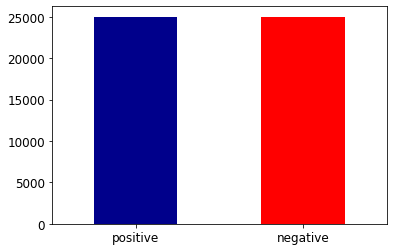

In [5]:
# Bar plot of the count of positive and negative reviews (they are equal)

df['sentiment'].value_counts().plot.bar(color=['darkblue', 'r'], rot=0, fontsize='large')
plt.show()

In [6]:
# Converting the sentiment values to integers (positive --> 1 and negative --> 0)

df.sentiment = [1 if tag == 'positive' else 0 for tag in df.sentiment]
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


<a id='preprocessing'></a>
# Data preprocessing
First, we use regular expressions to make the following transformations to the reviews:

- remove punctuation marks
- remove HTML tags
- remove URL's
- remove characters which are not letters or digits
- remove multiple whitespaces
- convert to lower case
- strip whitespaces from the beginning and the end

In [7]:
# Storing in "before_process" an example of review before preprocessing
# Defining and applying the function "process" performing the transformations of the reviews
# Storing in "after_process" the example of review after preprocessing

idx = 2132
before_process = df.iloc[idx][0]

def process(x):
    x = re.sub('[,\.!?:()"]', '', x)
    x = re.sub('<.*?>', ' ', x)
    x = re.sub('http\S+', ' ', x)
    x = re.sub('[^a-zA-Z0-9]', ' ', x)
    x = re.sub('\s+', ' ', x)
    return x.lower().strip()

df['review'] = df['review'].apply(lambda x: process(x))
after_process = df.iloc[idx][0]

Next, we remove stopwords from the reviews using the [word_tokenize()](https://www.nltk.org/_modules/nltk/tokenize.html#word_tokenize) function from the [nltk.tokenize]((https://www.nltk.org/api/nltk.tokenize.html) package.

In [8]:
# Storing in "stopwords_set" the set of English stopwords provided by nltk
# Defining and applying the function "sw_remove" which remove stopwords from reviews
# Storing in "after_removal" the example of review after tokenization

stopwords_set = set(nltk.corpus.stopwords.words('english'))

def sw_remove(x):
    words = nltk.tokenize.word_tokenize(x)
    filtered_list = [word for word in words if word not in stopwords_set]
    return ' '.join(filtered_list)

df['review'] = df['review'].apply(lambda x: sw_remove(x))
after_removal = sw_remove(after_process)

In [9]:
# Printing an example of review before preprocessing, after preprocessing, and after stopwords removal

print('\033[1m' + 'Example of review before preprocessing:' + '\033[0m' + '\n', before_process, '\n')
print('\033[1m' + 'Same review after preprocessing:' + '\033[0m' + '\n', after_process, '\n')
print('\033[1m' + 'Same review after preprocessing and stopwords removal:' + '\033[0m' + '\n', after_removal)

Example of review before preprocessing:
 I, too, found "Oppenheimer" to be a brilliant series and one of the finest offerings ever on American PBS. David Suchet was particularly effective as Edward Teller, as I recall, and the overall conception was spectacularly good. The only reason that the series doesn't rate a full 10/10 is for the low-budget production values in some areas. Actual content is absolutely first-rate in my recollection.<br /><br />The Oppenheimer miniseries will be released in the UK on July 31st! It will be a Region 2/PAL set, but it would seem that a Region 1/NTSC set should be soon in the offing.<br /><br />If you have a universal player in the US, you can order the series right now from Amazon UK.<br /><br />http://tinyurl.com/znyyq<br /><br />Huzzah!! 

Same review after preprocessing:
 i too found oppenheimer to be a brilliant series and one of the finest offerings ever on american pbs david suchet was particularly effective as edward teller as i recall and the

<a id='splitting'></a>
# Data splitting and tokenization
We use the [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function from the [sklearn.model_selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection) module to split our data into random training and test subsets.

In [10]:
from sklearn.model_selection import train_test_split

train_rev, test_rev, train_sent, test_sent = train_test_split(df['review'], df['sentiment'], test_size=0.1, random_state=42)

print('\033[1m' + 'train_rev.shape:' + '\033[0m', train_rev.shape)
print('\033[1m' + 'test_rev.shape:' + '\033[0m', test_rev.shape)
print('\033[1m' + 'train_sent.shape:' + '\033[0m', train_sent.shape)
print('\033[1m' + 'test_sent.shape:' + '\033[0m', test_sent.shape)

train_rev.shape: (45000,)
test_rev.shape: (5000,)
train_sent.shape: (45000,)
test_sent.shape: (5000,)


Next, we use the [Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) class from [keras.preprocessing.text](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/) module to create a dictionary of the "dict_size" most frequent words present in the reviews (a unique integer is assigned to each word), and we print some of its [attributes](https://faroit.com/keras-docs/1.2.2/preprocessing/text/). The index of the Tokenizer is computed the same way no matter how many most frequent words we use later, see this [post](https://stackoverflow.com/questions/46202519/keras-tokenizer-num-words-doesnt-seem-to-work).

In [11]:
from keras.preprocessing.text import Tokenizer

dict_size = 50000
tokenizer = Tokenizer(num_words=dict_size)
tokenizer.fit_on_texts(df['review'])

print('\033[1m' + 'Number of documents the tokenizer was trained on:' + '\033[0m' + '\n', tokenizer.document_count, '\n')
print('\033[1m' + 'length of the tokenizer index:' + '\033[0m' + '\n', len(tokenizer.word_index), '\n')
print('\033[1m' + 'First 50 entries of the tokenizer index:' + '\033[0m')
print(*list(tokenizer.word_index.items())[:50])

Number of documents the tokenizer was trained on:
 50000 

length of the tokenizer index:
 125791 

First 50 entries of the tokenizer index:
('movie', 1) ('film', 2) ('one', 3) ('like', 4) ('good', 5) ('time', 6) ('even', 7) ('would', 8) ('really', 9) ('story', 10) ('see', 11) ('well', 12) ('much', 13) ('get', 14) ('bad', 15) ('people', 16) ('great', 17) ('also', 18) ('first', 19) ('made', 20) ('make', 21) ('way', 22) ('could', 23) ('movies', 24) ('characters', 25) ('think', 26) ('watch', 27) ('character', 28) ('films', 29) ('two', 30) ('many', 31) ('seen', 32) ('never', 33) ('love', 34) ('plot', 35) ('life', 36) ('acting', 37) ('show', 38) ('best', 39) ('know', 40) ('little', 41) ('ever', 42) ('man', 43) ('better', 44) ('end', 45) ('scene', 46) ('still', 47) ('say', 48) ('scenes', 49) ('something', 50)


We use the [texts_to_sequences()](https://github.com/keras-team/keras/blob/v2.9.0/keras/preprocessing/text.py#L325-L337) function of the Tokenizer class to convert the training reviews and test reviews to lists of sequences of integers (tokens) "train_rev_tokens" and "test_rev_tokens", and we store in the numpy array "seq_lengths" the lengths of the sequences included in "train_rev_tokens" and "test_rev_tokens".

In [22]:
train_rev_tokens = tokenizer.texts_to_sequences(train_rev)
test_rev_tokens = tokenizer.texts_to_sequences(test_rev)
seq_lengths =  np.array([len(sequence) for sequence in train_rev_tokens + test_rev_tokens])

print('\033[1m' + 'seq_lengths:' + '\033[0m' + '\n', seq_lengths, '\n')

seq_lengths:
 [ 76 129  59 ...  63  90  84] 



If the lengths of the sequences were normally distributed, then a given length could be considered small or large when outside the interval

$$
\hbox{mean value of seq_lengths} \pm \hbox{2 standard deviations of seq_lengths,}
$$

and lengths not belonging to this interval would only represent 5% of the elements of seq_lengths (see the [68–95–99.7 rule](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule) in statistics). Here, we follow this heuristics, and thus define an upper bound for the length of sequences accordingly.

upper_bound = 295, and the percentage of sequence lengths smaller or equal than upper_bound is 94.55%


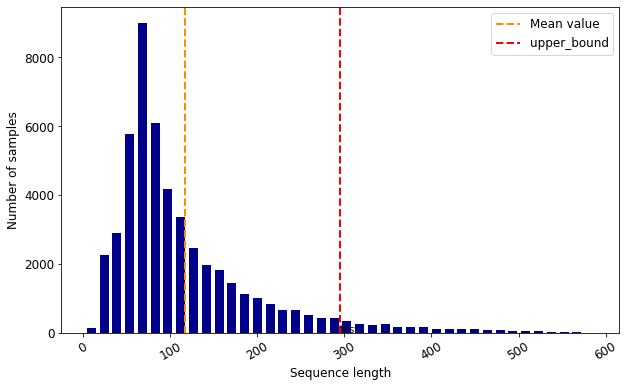

In [220]:
# Storing in "upper_bound" the upper bound for the length of sequences
# Computing the percentage of elements of "seq_lengths" smaller or equal than "upper_bound"

upper_bound = int(np.mean(seq_lengths) + 2 * np.std(seq_lengths))
percentage = stats.percentileofscore(seq_lengths, upper_bound)

print('\033[1m' + 'upper_bound = %d, and the percentage of sequence lengths \
smaller or equal than upper_bound is %.2f%%' % (upper_bound, round(percentage, 2)) + '\033[0m')

# Histogram plot of the lengths of the sequences in "train_rev_tokens" and "test_rev_tokens"

_, p_sequences = plt.subplots(figsize=(10,6))
p_sequences.hist(seq_lengths[seq_lengths < 2*upper_bound], color='darkblue', bins=40, rwidth=0.7)
p_sequences.axvline(np.mean(seq_lengths), color='darkorange', linestyle='--', linewidth=2, label='Mean value')
p_sequences.axvline(upper_bound, color='r', linestyle='--', linewidth=2, label='upper_bound')
#p_sequences.set_facecolor('#000030')

# Parameters of the plot

plt.xlabel('Sequence length', size='large')
plt.ylabel('Number of samples', size='large')
plt.rcParams['xtick.labelsize'] = 'large'
plt.rcParams['ytick.labelsize'] = 'large'
plt.text(upper_bound, 0, 'test')
plt.legend(fontsize='large')
plt.xticks(rotation=30)
plt.show()

Using the [pad_sequences()](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) function from [keras.preprocessing.sequence](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence) module, we transform "train_rev_tokens" and "test_rev_tokens" into 2D numpy arrays of shape (number of sequences, upper_bound). Sequences of smaller (resp. larger) length than "upper_bound" are extended (resp. truncated) to have length equal to "upper_bound".

In [14]:
from keras.preprocessing.sequence import pad_sequences

train_rev_pad = pad_sequences(train_rev_tokens, maxlen=upper_bound)
test_rev_pad = pad_sequences(test_rev_tokens, maxlen=upper_bound)

print('\033[1m' + 'train_rev_pad.shape:' + '\033[0m', train_rev_pad.shape)
print('\033[1m' + 'test_rev_pad.shape:' + '\033[0m', test_rev_pad.shape, '\n')
print('\033[1m' + 'Example of review after padding:' + '\033[0m' + '\n\n', train_rev_pad[idx])

train_rev_pad.shape: (45000, 295)
test_rev_pad.shape: (5000, 295) 

Example of review after padding:

 [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0 48038   136  1216  3217  2802
    27     1   123   

<a id='LSTM'></a>
# LSTM Model
We start by importing some classes from Keras:

- the [Sequential](https://keras.io/api/models/sequential/) class from the keras.models API (to group a linear stack of layers into a model)
- the [Embedding](https://keras.io/api/layers/core_layers/embedding/) class from the keras.layers API (to turn positive integers (indexes) into dense vectors of fixed size)
- the [LSTM](https://keras.io/api/layers/recurrent_layers/lstm/) class from the keras.layers API (to apply a long short-term memory layer to an input)
- the [Dropout](https://keras.io/api/layers/regularization_layers/dropout/) class from the keras.layers API (to apply dropout to the input)
- the [Dense](https://keras.io/api/layers/core_layers/dense/) class from the keras.layers API (to apply a regular densely-connected NN layer to an input)

In [15]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dropout, Dense

In [16]:
output_dim = 16
units_lstm = 16
r = 0.4

model = Sequential()
model.add(Embedding(input_dim=dict_size, output_dim=output_dim, input_length=upper_bound))
model.add(LSTM(units=units_lstm))
model.add(Dropout(r))
model.add(Dense(units=1, activation='sigmoid'))

We give a summary of the model using the [summary](https://keras.io/api/models/model/#summary-method) method of the [model class](https://keras.io/api/models/model/) of Keras. The "None" value stands for the (not yet defined) value of the batch size.

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 295, 16)           800000    
                                                                 
 lstm (LSTM)                 (None, 16)                2112      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 802,129
Trainable params: 802,129
Non-trainable params: 0
_________________________________________________________________


We import the [plot_model](https://keras.io/api/utils/model_plotting_utils/) function from the [keras.utils.vis_utils](https://faroit.com/keras-docs/2.0.8/visualization/) module to plot a schema of the model.

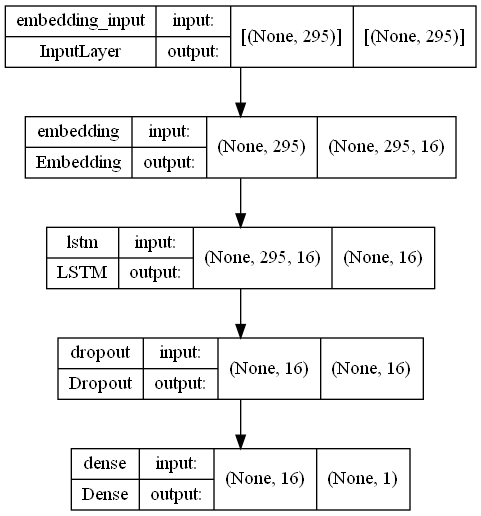

In [18]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True)

We compile the model for training with the following parameters:
- [adam](https://keras.io/api/optimizers/adam) as optimizer to use during training process (a combination of gradient descent with momentum and RMSP)
- [binary cross-entropy](https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class) (bce) between true labels and predicted labels as loss to minimise during training process
- [accuracy](https://keras.io/api/metrics/accuracy_metrics/#accuracy-class) as metric to display during training process (how often predicted labels equal true labels)

In [19]:
model.compile(optimizer='adam', loss='bce', metrics='accuracy')

We [train the model](https://keras.io/api/models/model_training_apis/#fit-method) with "train_rev_pad" as input array, "train_sent" as output array, [validation split](https://keras.io/api/models/model_training_apis/#:~:text=validation_split%3A%20Float%20between%200%20and,the%20end%20of%20each%20epoch.), batch size, number of epochs, and the option "shuffle=True" (to shuffle the training data before each epoch).

An epoch is a pass of the neural network over the entire training set and the batch size is the number of samples that are passed to the network at once. For each epoch, we thus have

$$
\hbox{number of training steps} = \frac{\hbox{length of training set - length of validation set}}{\hbox{batch size}}\;\!.
$$

In [20]:
validation_split = 0.2
batch_size = 512
epochs = 4

history = model.fit(train_rev_pad, train_sent, validation_split=validation_split, batch_size=batch_size, epochs=epochs, shuffle=True)

Epoch 1/4
71/71 [==============================] - 26s 336ms/step - loss: 0.6504 - accuracy: 0.6528 - val_loss: 0.4975 - val_accuracy: 0.8504
Epoch 2/4
71/71 [==============================] - 23s 323ms/step - loss: 0.3957 - accuracy: 0.8750 - val_loss: 0.3133 - val_accuracy: 0.8868
Epoch 3/4
71/71 [==============================] - 23s 328ms/step - loss: 0.2361 - accuracy: 0.9276 - val_loss: 0.2783 - val_accuracy: 0.8930
Epoch 4/4
71/71 [==============================] - 25s 356ms/step - loss: 0.1628 - accuracy: 0.9558 - val_loss: 0.2778 - val_accuracy: 0.8897


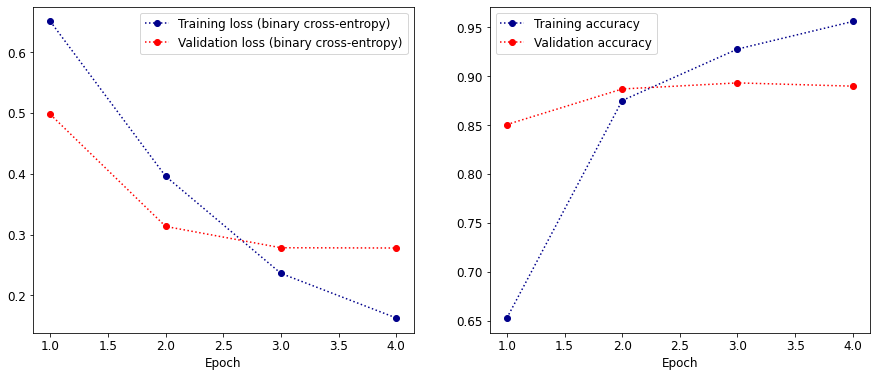

In [223]:
# Storing in "x_values" the values of the epochs

x_values = range(1, epochs+1)

# Plot of the training loss and validation loss (binary cross-entropy)

_, (p_loss, p_acc) = plt.subplots(1, 2, figsize=(15, 6))

p_loss.plot(x_values, history.history['loss'], color='darkblue', linestyle='dotted', marker='o',
            label='Training loss (binary cross-entropy)')
p_loss.plot(x_values, history.history['val_loss'], color='r', linestyle='dotted', marker='o',
            label='Validation loss (binary cross-entropy)')

p_acc.plot(x_values, history.history['accuracy'], color='darkblue', linestyle='dotted', marker='o',
            label='Training accuracy')
p_acc.plot(x_values, history.history['val_accuracy'], color='r', linestyle='dotted', marker='o',
            label='Validation accuracy')

# Parameters of the plot

plt.rcParams['xtick.labelsize'] = 'large'
plt.rcParams['ytick.labelsize'] = 'large'
p_loss.set_xlabel('Epoch', size='large')
p_loss.legend(fontsize='large')
p_acc.set_xlabel('Epoch', size='large')
p_acc.legend(fontsize='large')
plt.show()